In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dists
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d
from torch_utils import get_limits
from np_utils import simple_data
from tension_net import TensionNet
from bayes_factor import BayesFactor, SuspiciousnessKLDiv, LogSuspiciousness

In [2]:
X0, X1, X_prior = simple_data()
X0_tensor = torch.tensor(X0, dtype=torch.float)
X1_tensor = torch.tensor(X1, dtype=torch.float)
X_prior_tensor = torch.tensor(X_prior, dtype=torch.float)

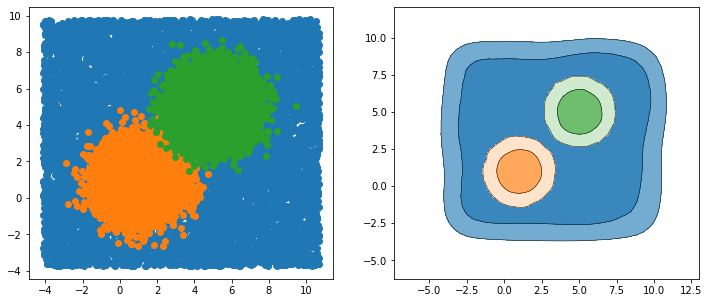

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(X_prior[:, 0], X_prior[:, 1])
axs[0].scatter(X0[:, 0], X0[:, 1])
axs[0].scatter(X1[:, 0], X1[:, 1])
kde_contour_plot_2d(axs[1], X_prior[:, 0], X_prior[:, 1])
kde_contour_plot_2d(axs[1], X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs[1], X1[:, 0], X1[:, 1])
plt.show()

## Visualising the contours of combined likelihood L_{AB}

In [4]:
tension = TensionNet(2)
theta = np.pi / 4
max_n = torch.tensor([np.cos(theta), np.sin(theta)])
tension.state_dict()["linear.weight"].copy_(max_n)
tension.state_dict()["linear.bias"].copy_(torch.tensor([0]))

tensor([0.])

In [119]:
X0_1d = tension(X0_tensor.float())
X1_1d = tension(X1_tensor.float())
X_combine = torch.cat((X0_1d, X1_1d))
def likelihood_f(z, X, cov=torch.tensor(1).float()):
    normal = dists.Normal(z.float(), cov)
    return normal.log_prob(X).sum(0)


In [132]:
x = torch.linspace(-5, 10, 100)
y = torch.linspace(-5, 10, 100)
grid_x, grid_y = torch.meshgrid(x, y)
grid_xy = torch.cat((grid_x.unsqueeze(2), grid_y.unsqueeze(2)), dim=2)

grid_z = tension(grid_xy).squeeze(2)
z = grid_z.reshape(-1)
z_llhd = likelihood_f(z, X_combine)
grid_z_llhd = z_llhd.reshape(grid_x.shape)

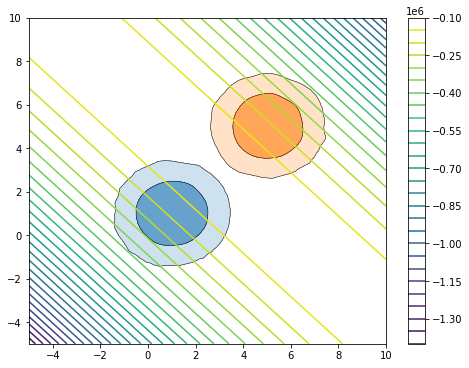

In [135]:
fig, axs = plt.subplots(figsize=(8, 6))

contour_plot = axs.contour(grid_x.detach().numpy(), grid_y.detach().numpy(), grid_z_llhd.detach().numpy(), levels=30)
kde_contour_plot_2d(axs, X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs, X1[:, 0], X1[:, 1])
fig.colorbar(contour_plot)